# Topic Modeling

In [13]:
# %conda create -n topic-modeling python=3.11 -y
# %conda activate topic-modeling
# %pip install pandas scikit-learn seaborn nltk
# %pip install bertopic[all] transformers "tokenizers>=0.20,<0.21"
# %pip install pyarrow  # if you need it

In [14]:
# %pip install numpy==1.24.4
# %pip install -U tokenizers
# %pip install bertopic
# %conda activate topic-modeling

In [15]:
# %pip install pandas numpy matplotlib spacy tqdm nltk seaborn scikit-learn transformers "tokenizers>=0.20,<0.21"
# %pip install openai
# %pip install --upgrade openai
# %pip install dotenv



In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vanikanoria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vanikanoria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# import scispacy
import re
import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
from openai import OpenAI
import hdbscan
import os
from dotenv import load_dotenv
import sqlite3


In [20]:
messages = pd.read_csv('messages.csv')

### First Attempt at Topic Modeling Using LDA

In [23]:
# Step 1: Convert text to document-term matrix
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(messages['content'])

# Step 2: Fit LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # 5 topics
lda.fit(dtm)

# Step 3: Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
appointment just good thank sarah follow therapy hello know dr
Topic 1:
work did accident injury job time body department personal prior
Topic 2:
injury questions investigation days 120 10 benefits sorry compensation final
Topic 3:
thank medical doctor need send good care center waiting morning
Topic 4:
work email accident days missed initial address answer job did
Topic 5:
know good thank morning let appointment hello form mileage work
Topic 6:
sarah appointment fl 555 claim 2024 medical thompson wilson address
Topic 7:
sarah thank claim 555 adjuster hi good information ok need
Topic 8:
555 appointment dr good 123 mri schedule 4567 fl scheduled
Topic 9:
thanks need good did hospital morning welcome day medical time


In [24]:
# Get topic for each document
topic_values = lda.transform(dtm)
messages['topic'] = topic_values.argmax(axis=1)

print(messages[['content', 'topic']].head())

                                             content  topic
0  Good morning, Ms. Cooper - when you have a few...      1
1  1. What is your job title/department? Animal C...      9
2  Thank you!!\n\nEmily Martinez\nSupervisor WC T...      7
3  Hi Sarah - According to the documents from you...      6
4  I was unable to make it to an appointment on 6...      5


## Use BERTopic for topic modeling

In [25]:
docs = messages['content'].tolist()
topic_model = BERTopic(language="english")
topics, probs = topic_model.fit_transform(docs)

messages['topic'] = topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,936,-1_to_you_the_my,"[to, you, the, my, and, for, me, have, that, in]","[Good afternoon,\nI am your workers compensati..."
1,0,127,0_mri_schedule_imaging_will,"[mri, schedule, imaging, will, an, with, the, ...","[Who can I schedule my MRI with ?, When is my ..."
2,1,92,1_appointment_appointments_rescheduled_at,"[appointment, appointments, rescheduled, at, m...",[Good morning. My job site is telling me they ...
3,2,74,2_bill_billing_hospital_paid,"[bill, billing, hospital, paid, send, them, pa...","[Good afternoon, \nI am contacting you in rega..."
4,3,64,3_claim_my_closed_number,"[claim, my, closed, number, im, just, was, mor...","[Good afternoon, I was just checking if you we..."
...,...,...,...,...,...
74,73,13,73_what_accident_body_worked,"[what, accident, body, worked, date, descripti...","[Good afternoon, How are you doing? Requesting..."
75,74,12,74_sign_signature_papers_signed,"[sign, signature, papers, signed, documents, l...","[It won't let me review and sign it, Good afte..."
76,75,12,75_about_minutes_available_claim,"[about, minutes, available, claim, trying, goo...","[Good morning, I have been trying to reach you..."
77,76,11,76_smith_letter_updated_paperwork,"[smith, letter, updated, paperwork, central, w...",[Dr. Smith completed the paperwork we just rec...


In [26]:
topics_df = topic_model.get_topic_info()
topics_df[topics_df.Topic != -1]

,Topic,Count,Name,Representation,Representative_Docs
1,0,127,0_mri_schedule_imaging_will,"[mri, schedule, imaging, will, an, with, the, ...","[Who can I schedule my MRI with ?, When is my ..."
2,1,92,1_appointment_appointments_rescheduled_at,"[appointment, appointments, rescheduled, at, m...",[Good morning. My job site is telling me they ...
3,2,74,2_bill_billing_hospital_paid,"[bill, billing, hospital, paid, send, them, pa...","[Good afternoon, \nI am contacting you in rega..."
4,3,64,3_claim_my_closed_number,"[claim, my, closed, number, im, just, was, mor...","[Good afternoon, I was just checking if you we..."
5,4,59,4_email_send_it_sent,"[email, send, it, sent, link, text, photos, ca...",[I sent to the email from my personal email ad...
...,...,...,...,...,...
74,73,13,73_what_accident_body_worked,"[what, accident, body, worked, date, descripti...","[Good afternoon, How are you doing? Requesting..."
75,74,12,74_sign_signature_papers_signed,"[sign, signature, papers, signed, documents, l...","[It won't let me review and sign it, Good afte..."
76,75,12,75_about_minutes_available_claim,"[about, minutes, available, claim, trying, goo...","[Good morning, I have been trying to reach you..."
77,76,11,76_smith_letter_updated_paperwork,"[smith, letter, updated, paperwork, central, w...",[Dr. Smith completed the paperwork we just rec...


## Topic modeling using HDBSCAN and BERTopic

In [27]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, metric='euclidean')
topic_model = BERTopic(hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(docs)

In [28]:
topics_df = topic_model.get_topic_info()
topics_df[topics_df.Topic != -1]

,Topic,Count,Name,Representation,Representative_Docs
1,0,120,0_mri_schedule_imaging_mediscan,"[mri, schedule, imaging, mediscan, an, will, r...","[Who can I schedule my MRI with ?, When will y..."
2,1,74,1_bill_billing_hospital_paid,"[bill, billing, hospital, paid, send, bills, p...","[Good afternoon, \nI am contacting you in rega..."
3,2,43,2_physical_therapy_script_approved,"[physical, therapy, script, approved, heard, s...",[Do you know when someone is going to contact ...
4,3,43,3_ste_arrival_located_myers,"[ste, arrival, located, myers, fort, orthopedi...",[Good afternoon Ms. Rodriguez Martinez! You ha...
5,4,42,4_forms_form_completed_edit,"[forms, form, completed, edit, end, month, sub...",[Hi - thank you for your prompt response - I c...
...,...,...,...,...,...
193,192,5,192_approval_approvement_waiting_they,"[approval, approvement, waiting, they, accept,...",[They already received a email of approval pri...
194,193,5,193_outlook_ioshttpsakamso0ukef_appchatclaims3...,"[outlook, ioshttpsakamso0ukef, appchatclaims3f...","[Yes, I would need to submit it. And when was ..."
195,194,5,194_xrays_quickcare_finger_legit,"[xrays, quickcare, finger, legit, 52623, cir, ...","[Hello Mr. Wilson , \n\nJust wanted to check i..."
196,195,5,195_assessment_glad_satisfied_everyone,"[assessment, glad, satisfied, everyone, 121920...",[Thanks for letting me know about your follow-...


## Rules based intent classification

In [29]:
import re
import pandas as pd

INTENT_PATTERNS_INS = {
    
    "Identity/Intro": [
        r"\b(i am|i'm)\b.*\b(adjuster|supervisor|claimant)\b",
        r"\bclaim( number| #|no\.)\b",
        r"\bthis is\b.*\b(adjuster|nurse|case manager)\b"
    ],
    "Information Request": [
        r"\bplease (provide|answer|confirm|send)\b",
        r"\bcan you\b", r"\bcould you\b", r"\bwould you\b",
        r"\bwhat is\b", r"\bwhich\b", r"\bwhen\b", r"\bhow\b", r"\?\s*$"
    ],
    "Status Request": [
        r"\b(status|update|follow ?up)\b.*\b(claim|case|appointment|paperwork)\b",
        r"\bbeen trying to reach\b", r"\bany (update|news)\b"
    ],
    "Status Update": [
        r"\b(i have|i've|i completed|i finished|i submitted|i sent)\b",
        r"\baccording to\b", r"\bper\b.*\b(doc|doctor|records)\b"
    ],
    "Scheduling/Appointment": [
        r"\bappointment\b|\bappt\b|\breschedul(e|ing)\b|\b(date|time)\b",
        r"\b(unable to make|missed)\b.*\bappointment\b",
        r"\b(dr\.?|doctor)\b.*\b(\d{1,2}[/-]\d{1,2}[/-]\d{2,4})\b"
    ],
    "Call/Contact Request": [
        r"\bgive me a call\b", r"\bcall me\b", r"\bplease call\b", r"\bphone\b"
    ],
    "Document Submission/Request": [
        r"\b(attached|attach|upload|sent)\b.*\b(form|paperwork|document|docs)\b",
        r"\bplease (send|upload)\b.*\b(form|document)\b"
    ],
    "Medical Update": [
        r"\b(ordered|prescribed|referred)\b.*\b(mri|x-?ray|pt|therapy|orthopedic|doctor)\b",
        r"\b(work restrictions?|light duty|out of work)\b"
    ],
    "Work Status": [
        r"\b(return(ed)? to work|went back to work|missed .* day)\b",
        r"\b(light duty|restricted duty)\b"
    ],
    "Acknowledgement/Thanks": [
        r"^(thanks|thank you|appreciate it|much appreciated)\b",
        r"^(okay|ok|got it|understood|sounds good)\b"
    ],
    "Affirmation/Negation": [
        r"^(yes|yep|yeah|no|nope)\b", r"\bno thanks\b"
    ],
    "Escalation/Complaint": [
        r"\b(tried|trying) to reach\b", r"\bnot (sure|happy|satisfied)\b",
        r"\bunfortunately\b"
    ],
    "Voicemail Reference": [
        r"\bgot your voicemail\b|\bleft (you )?a voicemail\b"
    ],
    "Decision/Preference": [
        r"\b(i (don’t|do not) want to change|i’ll stay with|i prefer)\b"
    ],
    "Greeting/Opening": [
        r"^(hi|hello|good (morning|afternoon|evening))\b"
    ],
    "Unreachable/Unavailability": [
        r"\b(sorry.*(late|delay)|just getting back)\b",
        r"\bunable to (make|attend|come)\b"
    ],
}

# Priority: first match wins (place specific/short intents before broader ones)
INTENT_PRIORITY = [
    "Acknowledgement/Thanks",
    "Affirmation/Negation",
    "Call/Contact Request",
    "Scheduling/Appointment",
    "Voicemail Reference",
    "Information Request",
    "Status Request",
    "Document Submission/Request",
    "Medical Update",
    "Work Status",
    "Decision/Preference",
    "Unreachable/Unavailability",
    "Identity/Intro",
    "Escalation/Complaint",
    "Status Update",
    # "Greeting/Opening",
]

# Precompile regexes
COMPILED = {k: [re.compile(p, re.IGNORECASE) for p in pats] for k, pats in INTENT_PATTERNS_INS.items()}

def classify_insurance_intent(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return "Unclassified"
    t = text.strip()
    for intent in INTENT_PRIORITY:
        for rx in COMPILED[intent]:
            if rx.search(t):
                return intent
    return "Unclassified"

# ---- Apply to your Series ----
messages['intent'] = messages['content'].apply(classify_insurance_intent)

In [30]:
messages.loc[messages['intent'] == 'Call/Contact Request', 'content'].tolist()

['Good morning, Ms. Cooper - when you have a few moments can you give me a call to discuss your accident? If you are unable to call, then please answer the following:\n\n1. What is your job title/department? \n2. Who is the department supervisor? \n3. Brief description of accident: \n4. Size of the dog and location on body that you were bitten: \n5. Prior injury to the affected body part? \n6. Any medical conditions that require maintenance medication? \n7. Have you missed any time from work as a result of this accident? \n\nThank you and have a good weekend!',
 'Hi would you please give me a call at 555 123 4567 i have couple of concerns that I would like to speak personally. Thank you',
 "Hi Sarah! This is Jennifer Smith, the adjuster for your workers' comp claim. I wanted to let you know that I called Wellness PT Center and they confirmed your physical therapy appointment is scheduled for tomorrow at 3 pm. Please feel free to give me a call if you have any questions - 555-123-4567. 

In [31]:
messages.loc[messages['intent'] == 'Status Request', 'content'].tolist()

["Hi there, the ER wanted me to schedule a follow up with my primary care doctor but they said they couldn't since it is a wirjma's comp case.  What do I do for a follow up? Thank you.",
 "Good morning, James! \nI've been trying to reach you to discuss your work comp. claim.  The number I have on file is (555) 123-4567. Is that the best contact number? \nThank you!",
 "I'm just checking status of my claim",
 'Just checking on status of my claim',
 'I did go for a followup and they dismissed me. I was diagnosed with plantar fascia. You can close the case. Thank you',
 'Good afternoon, I have been trying to reach you to complete an initial contact that takes about 15 minutes. Are you available today or tomorrow to complete that? I am here 8:30-5.',
 'Good Morning \nOur provider has been trying to reach you to schedule an MRI. Please contact MediScan at 800 555 1234. Thank You',
 'On 01/15/25, I received a text message from my attorney team (Robert Anderson, P.A (727) 555-1234). It appear

In [32]:
messages.loc[messages['intent'] ==  "Medical Update", 'content'].tolist()

['Hello! My doctor instructed me that he ordered an MRI for my right knee. Is there a list of doctors in the area who offer that service,',
 'Good morning,\nSorry I was off Friday. Yes please complete this form. You will continue to received it every month if you are placed out of work or on light duty. Please list if you are receiving any money other then form workers compensation or school board of riverside county. This is to report to the state of FL. such as child support, second job income, etc.\nThank you',
 'Received! Thank you! Did the doctor give you a return to work note? If not, our next step would be to get you set up at HealthFirst for continued treatment and to confirm any work restrictions you may have.',
 "They didn't but they said I wouldn't need to be on light duty",
 'We have referred you to orthopedic at Sunshine Regional Hospital. Please contact Sunshine Regional Orthopedic at 555-123-4567 Prompt 0. You are authorized for 1 Walk-In, please contact them to inquire 

In [34]:

# INTENT_PATTERNS_INS = {
#     "Greeting/Opening": [r"^(hi|hello|good (morning|afternoon|evening))\b"],
#     "Information Request": [r"\bplease (provide|answer|confirm|send)\b", r"\b(can|could|would)\b.*\b(you)\b", r"\?\s*$"],
#     "Status Request": [r"\b(status|update|follow ?up)\b"],
#     "Status Update": [r"\b(i (have|completed|submitted|sent|finished))\b", r"\baccording to\b"],
#     "Scheduling/Appointment": [r"\bappointment\b|\bappt\b|\breschedul", r"\bunable to make\b"],
#     "Call/Contact Request": [r"\b(give me a call|please call|call me)\b"],
#     "Document Submission/Request": [r"\b(attached|attach|upload|sent)\b.*\b(form|paperwork|document|docs)\b"],
#     "Medical Update": [r"\b(ordered|prescribed|referred)\b.*\b(mri|x-?ray|pt|therapy|orthopedic|doctor)\b"],
#     "Work Status": [r"\b(return(ed)? to work|went back to work|missed .* day)\b", r"\b(light duty|restricted duty)\b"],
#     "Acknowledgement/Thanks": [r"^(thanks|thank you|appreciate it)\b", r"^(ok|okay|got it|understood|sounds good)\b"],
#     "Affirmation/Negation": [r"^(yes|yep|yeah|no|nope)\b", r"\bno thanks\b"],
#     "Escalation/Complaint": [r"\b(tried|trying) to reach\b", r"\bunfortunately\b"],
#     "Voicemail Reference": [r"\bgot your voicemail\b|\bleft (you )?a voicemail\b"],
#     "Decision/Preference": [r"\b(i (don’t|do not) want to change|i’ll stay|i prefer)\b"],
#     "Unreachable/Unavailability": [r"\b(sorry.*(late|delay)|just getting back)\b", r"\bunable to (make|attend|come)\b"],
#     "Identity/Intro": [r"\bthis is\b.*\b(adjuster|nurse|case manager)\b", r"\bclaim( number| #|no\.)\b"]
# }

# COMPILED = {k: [re.compile(p, re.IGNORECASE) for p in pats]
#             for k, pats in INTENT_PATTERNS_INS.items()}

In [33]:
def classify_insurance_intents_multi(text: str):
    if not isinstance(text, str) or not text.strip():
        return []
    t = text.strip()
    hits = []
    for intent, regs in COMPILED.items():
        if any(rx.search(t) for rx in regs):
            hits.append(intent)
    return hits

In [35]:
INTENT_PRIORITY = [
    "Escalation/Complaint",
    "Medical Update",
    "Work Status",
    "Decision/Preference",
    "Unreachable/Unavailability",
    "Information Request",
    "Status Request",
    "Call/Contact Request",
    "Scheduling/Appointment",
    "Identity/Intro",
    "Status Update",
    "Acknowledgement/Thanks",
    "Affirmation/Negation",
    "Voicemail Reference",
    "Document Submission/Request",
    "Greeting/Opening",
]

def pick_primary_intent(intents: list[str]) -> str:
    if not intents:
        return "Unclassified"
    order = {k:i for i,k in enumerate(INTENT_PRIORITY)}
    return sorted(intents, key=lambda x: order.get(x, 999))[0]

In [ ]:
# Multi-label column
messages['intents'] = messages['content'].apply(classify_insurance_intents_multi)

# Primary (single) intent
messages['intent_primary'] = messages['intents'].apply(pick_primary_intent)

In [ ]:
all_intents = sorted(INTENT_PATTERNS_INS.keys())
for intent in all_intents:
    messages[f"intent__{intent}"] = messages['intents'].apply(lambda xs: int(intent in xs))

In [ ]:
messages['intents']

0       [Information Request, Scheduling/Appointment, ...
1           [Information Request, Scheduling/Appointment]
2                                [Acknowledgement/Thanks]
3       [Information Request, Status Request, Status U...
4       [Scheduling/Appointment, Unreachable/Unavailab...
                              ...                        
3074                               [Affirmation/Negation]
3075                                [Information Request]
3076    [Status Update, Document Submission/Request, G...
3077                                        [Work Status]
3078                             [Acknowledgement/Thanks]
Name: intents, Length: 3079, dtype: object

In [ ]:
# Sample rows that hit multiple intents
messages[messages['intents'].apply(lambda x: len(x) > 1)].head()



,thread_id,timestamp,role,content,topic,intent,intents,intent_primary,intent__Acknowledgement/Thanks,intent__Affirmation/Negation,...,intent__Greeting/Opening,intent__Identity/Intro,intent__Information Request,intent__Medical Update,intent__Scheduling/Appointment,intent__Status Request,intent__Status Update,intent__Unreachable/Unavailability,intent__Voicemail Reference,intent__Work Status
0,0,2024-06-07 14:47:59,supervisor,"Good morning, Ms. Cooper - when you have a few...",73,Call/Contact Request,"[Information Request, Scheduling/Appointment, ...",Information Request,0,0,...,1,0,1,0,1,0,0,0,0,0
1,0,2024-06-10 13:18:38,claimant,1. What is your job title/department? Animal C...,73,Scheduling/Appointment,"[Information Request, Scheduling/Appointment]",Information Request,0,0,...,0,0,1,0,1,0,0,0,0,0
3,0,2024-07-01 19:03:40,supervisor,Hi Sarah - According to the documents from you...,1,Scheduling/Appointment,"[Information Request, Status Request, Status U...",Information Request,0,0,...,1,0,1,0,1,1,1,0,0,0
4,0,2024-07-02 3:35:15,claimant,I was unable to make it to an appointment on 6...,-1,Scheduling/Appointment,"[Scheduling/Appointment, Unreachable/Unavailab...",Unreachable/Unavailability,0,0,...,0,0,0,0,1,0,0,1,0,0
5,0,2024-07-09 16:12:15,supervisor,"Hi Sarah, I hope you're doing well. Could you ...",1,Scheduling/Appointment,"[Information Request, Status Update, Schedulin...",Information Request,0,0,...,1,0,1,0,1,0,1,0,0,0


In [ ]:
# Distribution of primary intents
messages['intent_primary'].value_counts()

intent_primary
Information Request            740
Unclassified                   641
Scheduling/Appointment         346
Greeting/Opening               283
Acknowledgement/Thanks         261
Status Update                  177
Call/Contact Request           167
Medical Update                 117
Affirmation/Negation            96
Work Status                     91
Escalation/Complaint            70
Status Request                  41
Identity/Intro                  32
Unreachable/Unavailability       8
Document Submission/Request      6
Voicemail Reference              3
Name: count, dtype: int64

In [ ]:
#Plot distribution of primary intents
plt.figure(figsize=(12,6))
sns.countplot(data=messages, y='intent_primary', order=messages['intent_primary'].value_counts().index)
plt.title('Distribution of Primary Intents')
plt.xlabel('Count')
plt.ylabel('Primary Intent')
plt.show()

In [41]:
messages[messages['intent_primary'] == 'Unclassified']['content'].to_csv('unclassified_intents.csv', index=False)

## Using LLM

In [42]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [43]:
COMPACT_LABELS = [
  "Greeting/Acknowledgement",
  "Request",
  "Scheduling",
  "Contact/Logistics",
  "Documents",
  "Medical/Work Update",
  "Escalation/Decision/Identity/Other",
]

In [44]:
# Role-aware primary ordering (same idea you used)
PRIORITY_DEFAULT = ["Request","Scheduling","Documents","Medical/Work Update",
                    "Contact/Logistics","Greeting/Acknowledgement","Escalation/Decision/Identity/Other"]
PRIORITY_BY_ROLE = {
    "claimant": ["Scheduling","Request","Contact/Logistics","Documents","Medical/Work Update",
                 "Greeting/Acknowledgement","Escalation/Decision/Identity/Other"],
    "adjuster": ["Request","Documents","Contact/Logistics","Scheduling","Medical/Work Update",
                 "Greeting/Acknowledgement","Escalation/Decision/Identity/Other"],
}

In [45]:
def pick_primary_compact(intents, role=None):
    if not intents: 
        return "Escalation/Decision/Identity/Other"
    pri = PRIORITY_BY_ROLE.get((role or "").strip().lower(), PRIORITY_DEFAULT)
    order = {k:i for i,k in enumerate(pri)}
    return sorted(intents, key=lambda x: order.get(x, 999))[0]

In [46]:
# Few-shot examples help the model stay consistent
FEW_SHOTS = [
  {
    "role":"user",
    "content":'Role: claimant\nMessage: "Hi Sarah, could you please send me the form? I missed my appointment on 7/01."'
  },
  {
    "role":"assistant",
    "content":(
      '{"intents":["Request","Scheduling","Documents"],'
      '"intent_primary":"Request",'
      '"rationale":"Asks to send a form (Request); mentions missed appointment (Scheduling); refers to form (Documents).",'
      '"scores":{"Greeting/Acknowledgement":0.05,"Request":0.88,"Scheduling":0.72,'
      '"Contact/Logistics":0.20,"Documents":0.66,"Medical/Work Update":0.15,'
      '"Escalation/Decision/Identity/Other":0.10}}'
    )
  },
]


In [47]:
SYSTEM = (
  "You label claimant–adjuster messages with multi-label intents.\n"
  'Allowed labels: ["Greeting/Acknowledgement","Request","Scheduling","Contact/Logistics",'
  '"Documents","Medical/Work Update","Escalation/Decision/Identity/Other"].\n'
  "Return STRICT JSON with: intents (array), intent_primary (string), rationale (string), "
  "and scores (object mapping each allowed label to a number 0..1 = likelihood).\n"
  "Pick intents where score >= 0.5. Prefer actionable categories over pleasantries."
)

In [48]:
# Strict JSON schema (Responses API structured outputs)
INTENT_SCHEMA = {
  "name": "intent_schema",
  "schema": {
    "type": "object",
    "properties": {
      "intents": {"type":"array","items":{"type":"string","enum": COMPACT_LABELS},"uniqueItems": True},
      "intent_primary": {"type":"string","enum": COMPACT_LABELS},
      "rationale": {"type":"string"},
      "scores": {
        "type":"object",
        "properties": {lbl: {"type":"number","minimum":0,"maximum":1} for lbl in COMPACT_LABELS},
        "required": COMPACT_LABELS,
        "additionalProperties": False
      }
    },
    "required": ["intents","intent_primary","rationale","scores"],
    "additionalProperties": False
  },
  "strict": True
}


In [49]:
#probability based picker of primary intent
def pick_primary_by_scores(
    scores: dict, role: str | None = None, tie_margin: float = 0.01, role_prior_bonus: float = 0.0
) -> str:
    PRIORITY_DEFAULT = ["Request","Scheduling","Documents","Medical/Work Update",
                        "Contact/Logistics","Greeting/Acknowledgement","Escalation/Decision/Identity/Other"]
    PRIORITY_BY_ROLE = {
        "claimant": ["Scheduling","Request","Contact/Logistics","Documents","Medical/Work Update",
                     "Greeting/Acknowledgement","Escalation/Decision/Identity/Other"],
        "adjuster": ["Request","Documents","Contact/Logistics","Scheduling","Medical/Work Update",
                     "Greeting/Acknowledgement","Escalation/Decision/Identity/Other"],
    }
    pri = PRIORITY_BY_ROLE.get((role or "").strip().lower(), PRIORITY_DEFAULT)
    if not scores: 
        return "Escalation/Decision/Identity/Other"

    # Optional tiny role prior to break near-ties
    if role_prior_bonus > 0:
        rank = {l:i for i,l in enumerate(pri)}
        m = max(1, len(pri)-1)
        scores = {l: float(s) + role_prior_bonus*(1 - rank.get(l, m)/m) for l,s in scores.items()}

    best = max(scores.values())
    tied = [l for l, s in scores.items() if abs(s - best) <= tie_margin]
    if len(tied) == 1:
        return tied[0]
    order = {l:i for i,l in enumerate(pri)}
    return sorted(tied, key=lambda l: order.get(l, 999))[0]

In [50]:
def classify_message_with_openai(content: str, role: str | None = None, model: str = "gpt-4o-mini"):
    """
    Works with both the new Responses API (input=...) and the legacy Chat Completions API.
    Expects the model to return: intents[], intent_primary (ignored/overwritten), rationale, scores{label:prob}
    """

    def _as_block(role_name, text):
        return {"role": role_name, "content": [{"type": "text", "text": text}]}

    user_text = f'Role: {role or "unknown"}\nMessage: "{(content or "").strip()}"'
    messages_blocks = [{"role": "system", "content": [{"type": "text", "text": SYSTEM}]}]
    for ex in FEW_SHOTS:
        messages_blocks.append(_as_block(ex["role"], ex["content"]))
    messages_blocks.append(_as_block("user", user_text))

    # ---- Try Responses API first ----
    try:
        resp = client.responses.create(
            model=model,
            input=messages_blocks,   # <- Responses API uses 'input'
            response_format={"type": "json_schema", "json_schema": INTENT_SCHEMA},
            temperature=0
        )

        if getattr(resp, "output_parsed", None):
            data = resp.output_parsed
        else:
            output = getattr(resp, "output", []) or []
            text = None
            if output and getattr(output[0], "content", None):
                first = output[0].content[0]
                text = getattr(first, "text", None) or getattr(first, "input_text", None)
            if not text:
                raise ValueError(f"Could not extract text from Responses output: {resp}")
            data = json.loads(text)

        # --- normalize intents from scores (>= 0.5) ---
        if "scores" in data and isinstance(data["scores"], dict):
            inferred = [lbl for lbl, sc in data["scores"].items() if sc >= 0.5]
            if set(inferred) != set(data.get("intents", [])):
                data["intents"] = inferred

            data["intent_primary"] = pick_primary_by_scores(
                data["scores"], role=role, tie_margin=0.01, role_prior_bonus=0.02
            )
        else:
            data["intent_primary"] = pick_primary_compact(data.get("intents", []), role)

        return data

    except TypeError as e:
        print("Responses API TypeError, falling back to Chat Completions:", e)
    except Exception as e:
        print("Responses API failed, falling back to Chat Completions:", repr(e))

    # ---- Fallback: Chat Completions ----
    legacy_messages = []
    for blk in messages_blocks:
        text_chunks = [c["text"] for c in blk["content"] if c.get("type") == "text"]
        legacy_messages.append({"role": blk["role"], "content": "\n".join(text_chunks)})

    completion = client.chat.completions.create(
        model=model,
        messages=legacy_messages,
        temperature=0
    )
    raw = completion.choices[0].message.content.strip()
    data = json.loads(raw)

    # --- normalize intents from scores (>= 0.5) ---
    if "scores" in data and isinstance(data["scores"], dict):
        inferred = [lbl for lbl, sc in data["scores"].items() if sc >= 0.5]
        if set(inferred) != set(data.get("intents", [])):
            data["intents"] = inferred

        data["intent_primary"] = pick_primary_by_scores(
            data["scores"], role=role, tie_margin=0.01, role_prior_bonus=0.02
        )
    else:
        data["intent_primary"] = pick_primary_compact(data.get("intents", []), role)

    return data

In [51]:
messages.iloc[1]

thread_id                                                                              0
timestamp                                                            2024-06-10 13:18:38
role                                                                            claimant
content                                1. What is your job title/department? Animal C...
topic                                                                                 73
intent                                                            Scheduling/Appointment
intents                                    [Information Request, Scheduling/Appointment]
intent_primary                                                       Information Request
intent__Acknowledgement/Thanks                                                         0
intent__Affirmation/Negation                                                           0
intent__Call/Contact Request                                                           0
intent__Decision/Pref

In [52]:
messages.iloc[1]['content']

"1. What is your job title/department? Animal Care Specialist at Riverside County Animal Services.\n2. Who is the department supervisor? Robert Brown\n3. Brief description of accident: As I was exiting the dog's kennel he got excited and and started jumping up and biting at me.\n4. Size of the dog and location on body that you were bitten: Large sized dog and under my right upper arm.\n5. Prior injury to the affected body part? No\n6. Any medical conditions that require maintenance medication? No\n7. Have you missed any time from work as a result of this accident? Just 2 hours on the date of the accident (6/3/24) because I left earlier to see a doctor.\n\nThanks!\n-Sarah Cooper"

In [53]:
msg_text = messages.iloc[1]['content']
message = messages.iloc[1]
role = "claimant"  # or "adjuster", or None

In [54]:
result = classify_message_with_openai(
    content=msg_text,
    role=role # optional, but helps pick primary intent
)

print("Full classification result:", result)
print("Detected intents:", result.get("intents"))
print("Primary intent:", result.get("intent_primary"))
print("Rationale:", result.get("rationale", ""))

Responses API TypeError, falling back to Chat Completions: Responses.create() got an unexpected keyword argument 'response_format'
Full classification result: {'intents': ['Medical/Work Update', 'Documents'], 'intent_primary': 'Medical/Work Update', 'rationale': 'Provides detailed information about the accident and its impact on work (Medical/Work Update); includes information that may require documentation (Documents).', 'scores': {'Greeting/Acknowledgement': 0.05, 'Request': 0.1, 'Scheduling': 0.15, 'Contact/Logistics': 0.1, 'Documents': 0.6, 'Medical/Work Update': 0.85, 'Escalation/Decision/Identity/Other': 0.1}}
Detected intents: ['Medical/Work Update', 'Documents']
Primary intent: Medical/Work Update
Rationale: Provides detailed information about the accident and its impact on work (Medical/Work Update); includes information that may require documentation (Documents).


## using both regex classifier and LLM

In [55]:
COMPACT_LABELS = [
  "Greeting/Acknowledgement","Request","Scheduling","Contact/Logistics",
  "Documents","Medical/Work Update","Escalation/Decision/Identity/Other"
]

INTENT_SCHEMA_CHAT = {
  "name": "intent_schema",
  "schema": {
    "type": "object",
    "properties": {
      "intents": {
        "type": "array",
        "items": {"type": "string", "enum": COMPACT_LABELS}
      },
      "intent_primary": {"type": "string", "enum": COMPACT_LABELS},
      "rationale": {"type": "string"},
      # Simpler 'scores' map; avoid per-label required
      "scores": {
        "type": "object",
        "additionalProperties": {"type": "number"}
      }
    },
    "required": ["intents", "intent_primary"]
  }
}

In [75]:
def classify_hybrid(
    content,
    role=None,
    regex_hits=None,
    medical_flag=False,
    model="gpt-5-nano",
    regex_boost=0.10,
    score_threshold=0.50,
    tie_margin=0.01,
    role_prior_bonus=0.02,
):

    # 1) short-circuit: decisive regex?
    if regex_hits and ("Request" in regex_hits or "Scheduling" in regex_hits):
        # quick deterministic result
        intents = list(set(regex_hits))
        if medical_flag and "Medical/Work Update" not in intents:
            intents.append("Medical/Work Update")
        return {
            "intents": intents,
            "scores": {lbl: 0.9 for lbl in intents},   # synthetic high confidence
            "intent_primary": pick_primary_compact(intents, role)
        }

        
    hints = ""

    if regex_hits:
        hints += f"\nHints (regex): {', '.join(regex_hits)}"
    if medical_flag:
        hints += "\nHint: medical evidence found."
    user_msg = f'Role: {role or "unknown"}\nMessage: "{(content or "").strip()}"{hints}'

    completion = client.chat.completions.create(
        model=model,
        messages=(
            [{"role": "system", "content": SYSTEM}]
            + FEW_SHOTS
            + [{"role": "user", "content": user_msg}]
        ),
        # temperature=0,
        response_format={"type": "json_schema", "json_schema": INTENT_SCHEMA_CHAT}
    )

    raw = completion.choices[0].message.content
    data = json.loads(raw)

    # --- fuse scores + regex boosts ---
    scores = data.get("scores", {}) if isinstance(data.get("scores"), dict) else {}

    # boost + thresholds
    if regex_hits and scores:
        for lbl in regex_hits:
            if lbl in scores:
                scores[lbl] = min(1.0, float(scores[lbl]) + regex_boost)

    if medical_flag:
        scores["Medical/Work Update"] = max(0.60, float(scores.get("Medical/Work Update", 0.0)))

    if scores:
        inferred = [lbl for lbl, sc in scores.items() if sc >= score_threshold]
        data["intents"] = inferred

        data["intent_primary"] = pick_primary_by_scores(
            scores, role=role, tie_margin=tie_margin, role_prior_bonus=role_prior_bonus
        )
    else:
        data["intent_primary"] = pick_primary_compact(data.get("intents", []), role)

    return data

In [ ]:
# Compact patterns (merged intents)
COMPACT_PATTERNS = {
    "Greeting/Acknowledgement": [
        r"^(?:hi|hello|hey|yes|good (?:morning|afternoon|evening))\b",
        r"^(?:thanks|thank you|thx|ty|ok|okay|got it|understood|sounds good|noted|will do|done|perfect|great|awesome)\b",
        r"\b(?:got|received|left) (?:your )?voicemail\b|\bVM\b",
    ],
    "Request": [
        r"\bplease (?:provide|answer|confirm|send|advise)\b",
        r"\b(?:can|could|would|will)\b.*\b(?:you|u)\b",
        r"\b(?:status|update|follow ?up|check(?:ing)? in)\b",
        r"\bany (?:update|news|progress)\b|\bETA\b",
        r"\?\s*$",
    ],
    "Scheduling": [
        r"\b(?:appointment|appt|reschedul(?:e|ing)|cancel(?:l)?)\b",
        r"\b(?:date|time|slot|availability|available)\b",
        r"\b(?:unable|couldn'?t|can't) to (?:make|attend|come)\b",
        r"\b(?:monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b",
        r"\b\d{1,2}[/-]\d{1,2}(?:[/-]\d{2,4})?\b|\b\d{1,2}:\d{2}\s?(?:am|pm)\b",
    ],
    "Contact/Logistics": [
        r"\b(?:give|gave) me a call\b|\bplease call\b|\bcall me\b|\bphone\b",
        r"\b(?:text|email) me\b|\bsend me a text\b|\breach (?:me|out)\b",
        r"\b\d{3}[-.)\s]?\d{3}[-.\s]?\d{4}\b",
        r"\b(?:sorry.*(?:late|delay)|just getting back|unavailable|busy (?:today|now|at that time))\b",
    ],
    "Documents": [
        r"\b(?:attach(?:ed)?|enclosed|upload(?:ed)?|sent)\b.*\b(?:form|paperwork|document|docs|letter|report)\b",
        r"\bplease (?:send|upload|fill|complete)\b.*\b(?:form|paperwork|document|docs)\b",
        r"\b(?:DWC-?\d+|FROI|HIPAA|release|authorization)\b",
    ],
    "Medical/Work Update": [
        r"\b(?:ordered|prescribed|referred)\b.*\b(?:mri|x-?ray|ct|ultrasound|pt|physical therapy|orthopedic|injection|rx)\b",
        r"\bdoctor\b.*\b(?:note|order|visit|referral)\b|\b(?:pharmacy|medication|rx|script)\b",
        r"\b(?:return(?:ed)?|went back|back) to work\b|\bmissed .* (?:day|days)\b|\b(light duty|restricted duty|work restrictions?)\b|\bout of work\b|\bOOO\b",
    ],
    "Escalation/Decision/Identity/Other": [
        r"\b(?:tried|trying|been trying) to reach\b|\bstill waiting\b|\bdelay(?:ed)?\b|\bunfortunately\b",
        r"\bnot (?:happy|satisfied|okay|sure)\b|\bconcern\b|\bcomplain\b",
        r"\b(?:i (?:don’t|do not|won't) want to change|i’ll stay|i prefer|i choose)\b",
        r"\bthis is\b.*\b(?:adjuster|nurse|case manager|supervisor|claimant)\b|\bclaim(?: number| #|no\.)\b|\bworkers'? compensation\b",
    ],
}

	# •	Greeting/Acknowledgement – Simple greetings, thanks, confirmations, or acknowledgment of receipt.
	# •	Request – Asking for information, status, updates, or follow-ups.
	# •	Scheduling – Discussing, setting, or changing appointments, dates, or times.
	# •	Contact/Logistics – Sharing or requesting contact methods, availability, or call-back instructions.
	# •	Documents – Sending, requesting, or referencing forms, paperwork, or official documents.
	# •	Medical/Work Update – Providing updates on medical treatments, work status, or related restrictions.
	# •	Escalation/Decision/Identity/Other – Complaints, dissatisfaction, decisions, delays, or identity/role references.

COMPILED_COMPACT = {k: [re.compile(p, re.IGNORECASE) for p in v] for k, v in COMPACT_PATTERNS.items()}

def classify_compact_multi(msg_text) -> list[str]:
    """
    Returns a list of all regex-matched intents for a given message.
    message can be a string or dict with 'content'.
    """
    if isinstance(msg_text, dict):
        text = msg_text.get("content", "")
    else:
        text = msg_text or ""
    text = text.strip().lower()
    if not text:
        return []

    hits = []
    for intent, patterns in COMPILED_COMPACT.items():
        if any(rx.search(text) for rx in patterns):
            hits.append(intent)
    return hits

In [77]:
MEDICAL_PATTERNS = [
    r"\bdoctor\b", r"\bdr\.\b", r"\bappointment\b", r"\bappt\b",
    r"\bMRI\b", r"\bx-?ray\b", r"\bCT\b", r"\bultrasound\b",
    r"\bphysical therapy\b", r"\bPT\b", r"\borthopedic\b",
    r"\binjection\b", r"\bprescribed\b", r"\bpharmacy\b",
    r"\bmedication\b", r"\brx\b", r"\bscript\b",
]

COMPILED_MEDICAL = [re.compile(p, re.IGNORECASE) for p in MEDICAL_PATTERNS]

def found_medical_entities(msg_text) -> bool:
    """
    Returns True if the message contains medical-related terms.
    message can be a string or dict with 'content'.
    """
    if isinstance(msg_text, dict):
        text = msg_text.get("content", "")
    else:
        text = msg_text or ""
    text = text.strip()
    return any(rx.search(text) for rx in COMPILED_MEDICAL)

In [78]:
# Suppose you’ve already run your regex classifier:
regex_hits = classify_compact_multi(msg_text)
medical_flag = found_medical_entities(msg_text)

# Now run hybrid classification:
result = classify_hybrid(
    content=message["content"],
    role=message.get("role"),
    regex_hits=regex_hits,
    medical_flag=medical_flag
)

print(result["intents"])
print(result["intent_primary"])

['Medical/Work Update', 'Scheduling']
Scheduling


### Apply to messages dataframe

In [80]:
#apply to subset of messages DataFrame
from tqdm.auto import tqdm
tqdm.pandas()

messages_subset = messages.head(50).copy()
messages_subset['regex_hits'] = messages_subset['content'].progress_apply(classify_compact_multi)
messages_subset['medical_flag'] = messages_subset['content'].progress_apply(found_medical_entities)    
messages_subset['hybrid_classification'] = messages_subset.progress_apply(
    lambda row: classify_hybrid(
        content=row['content'],
        role=row.get('role'),
        regex_hits=row['regex_hits'],
        medical_flag=row['medical_flag']
    ),
    axis=1
)
messages_subset['intents_hybrid_classification'] = messages_subset['hybrid_classification'].progress_apply(lambda x: x.get('intents', []))
messages_subset['intent_primary_hybrid'] = messages_subset['hybrid_classification'].progress_apply(
    lambda x: x.get('intent_primary', 'Unclassified'))

100%|██████████| 50/50 [00:00<00:00, 4945.53it/s]


100%|██████████| 50/50 [00:00<00:00, 268865.64it/s]


In [ ]:
messages_subset.to_csv('messages_subset_with_hybrid_classification.csv', index=False)

In [84]:
messages['regex_hits'] = messages['content'].progress_apply(classify_compact_multi)
messages['medical_flag'] = messages['content'].progress_apply(found_medical_entities)    
messages['hybrid_classification'] = messages.progress_apply(
    lambda row: classify_hybrid(
        content=row['content'],
        role=row.get('role'),
        regex_hits=row['regex_hits'],
        medical_flag=row['medical_flag']
    ),
    axis=1
)
messages['intents_hybrid_classification'] = messages['hybrid_classification'].progress_apply(lambda x: x.get('intents', []))
messages['intent_primary_hybrid'] = messages['hybrid_classification'].progress_apply(
    lambda x: x.get('intent_primary', 'Unclassified'))

100%|██████████| 3079/3079 [00:00<00:00, 1789918.51it/s]


In [102]:
messages['intents_hybrid_classification'] 

0       [Request, Greeting/Acknowledgement, Scheduling...
1                       [Medical/Work Update, Scheduling]
2           [Greeting/Acknowledgement, Contact/Logistics]
3       [Request, Greeting/Acknowledgement, Scheduling...
4                       [Scheduling, Medical/Work Update]
                              ...                        
3074                 [Escalation/Decision/Identity/Other]
3075            [Request, Documents, Medical/Work Update]
3076                [Greeting/Acknowledgement, Documents]
3077                    [Scheduling, Medical/Work Update]
3078                           [Greeting/Acknowledgement]
Name: intents_hybrid_classification, Length: 3079, dtype: object

In [85]:
messages.to_csv('all_messages_with_intent.csv')

## Plot with intents

In [97]:
# Define order from all messages
order = messages['intent_primary_hybrid'].value_counts(normalize=True).index

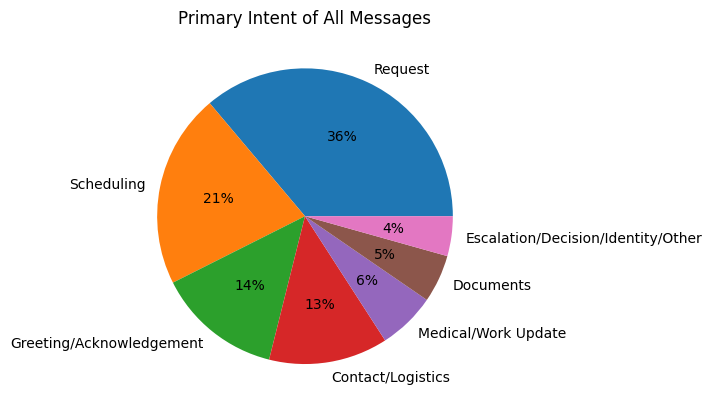

In [98]:
# First pie chart (all messages)
counts_all = messages['intent_primary_hybrid'].value_counts(normalize=True).reindex(order, fill_value=0)
plt.pie(counts_all.values, labels=counts_all.index, autopct='%.f%%')
plt.title('Primary Intent of All Messages')
plt.show()

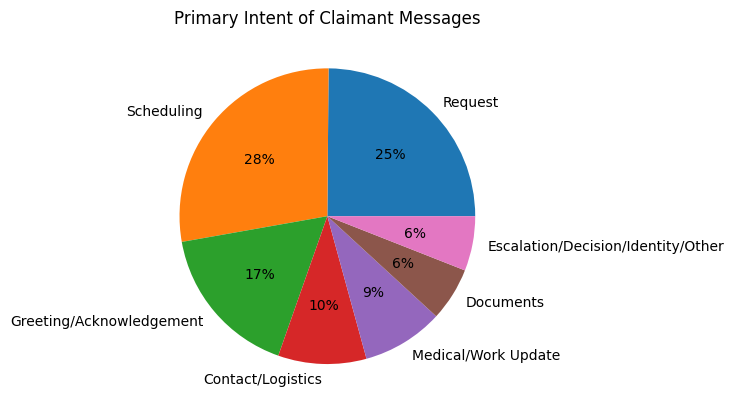

In [99]:
# Second pie chart (claimant messages)
counts_claimant = messages.loc[messages['role'] == 'claimant', 'intent_primary_hybrid'] \
                           .value_counts(normalize=True) \
                           .reindex(order, fill_value=0)
plt.pie(counts_claimant.values, labels=counts_claimant.index, autopct='%.f%%')
plt.title('Primary Intent of Claimant Messages')
plt.show()

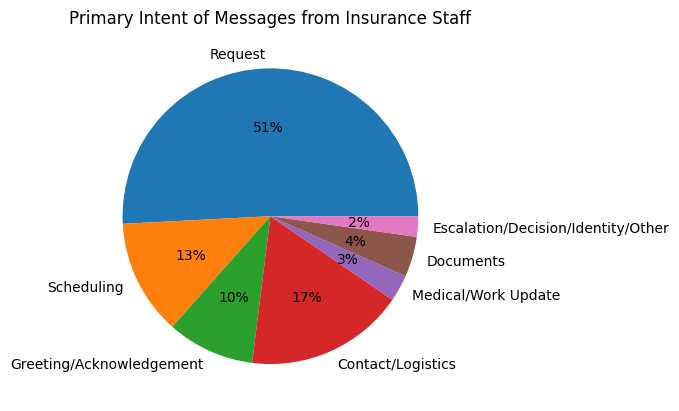

In [101]:
# Insurance staff pie chart (non-claimant)
counts_staff = (
    messages.loc[messages['role'] != 'claimant', 'intent_primary_hybrid']
    .value_counts(normalize=True)
    .reindex(order, fill_value=0)  # match order & fill missing
)

counts_staff.plot(kind='pie', labels=counts_staff.index, autopct='%.f%%', title='Primary Intent of Messages from Insurance Staff')
plt.ylabel("")  # remove y-label for cleaner look
plt.show()

## Looking at all intents - not just primary ones

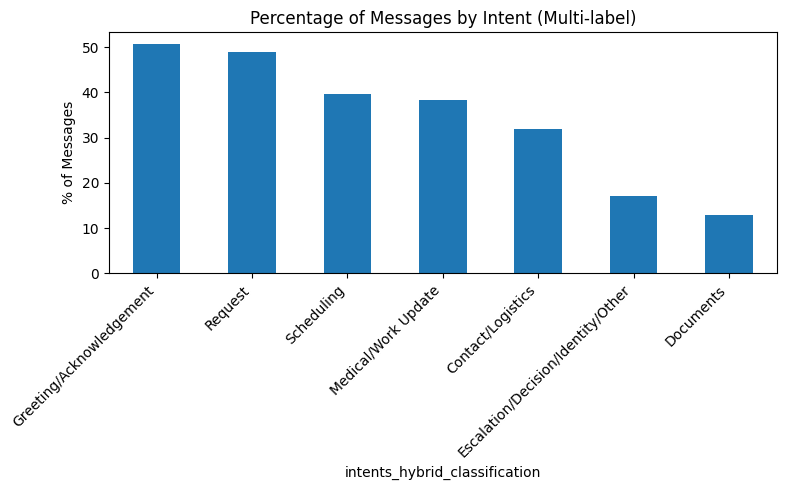

In [104]:
# Example: explode the list of intents into separate rows
df_exploded = messages.explode('intents_hybrid_classification')

# Count how many times each intent appears
intent_counts = df_exploded['intents_hybrid_classification'].value_counts()*100/len(messages)

# Plot as bar chart
plt.figure(figsize=(8, 5))
intent_counts.plot(kind='bar')
plt.ylabel('% of Messages')
plt.title('Percentage of Messages by Intent (Multi-label)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

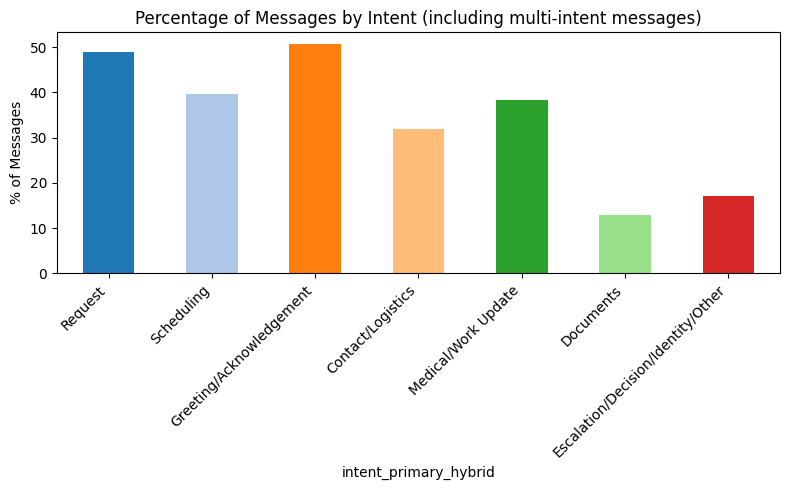

In [107]:
intent_counts = intent_counts.reindex(order)  # align to same order

# Plot with same order & consistent colors
colors = plt.cm.tab20.colors  # pick a palette
plt.figure(figsize=(8, 5))
intent_counts.plot(kind='bar', color=[colors[i % len(colors)] for i in range(len(order))])
plt.ylabel('% of Messages')
plt.title('Percentage of Messages by Intent (including multi-intent messages)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [110]:
messages = messages.rename({'intents_hybrid_classification': 'all_intents', 'intent_primary_hybrid':'primary_intent'})

In [ ]:
messages = messages.reset_index().rename(columns={'index': 'message_id'})

In [111]:
def add_column(db_path, table_name, column_name, column_type="TEXT"):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute(f"ALTER TABLE {table_name} ADD COLUMN {column_name} {column_type}")
    conn.commit()
    conn.close()

# Example:
add_column("claims.db", "messages", "all_intents", "TEXT")
add_column("claims.db", "messages", "primary_intent", "TEXT")

OperationalError: duplicate column name: all_intents

In [108]:
def ensure_column(db_path: str, table: str, column: str, coltype: str = "TEXT"):
    """Add a column if it doesn't exist."""
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    # check existing columns
    cols = [r[1] for r in cur.execute(f"PRAGMA table_info({table})").fetchall()]
    if column not in cols:
        cur.execute(f"ALTER TABLE {table} ADD COLUMN {column} {coltype}")
        conn.commit()
    conn.close()

def update_column_from_csv(
    csv_path: str,
    db_path: str,
    table_name: str,
    match_column: str,
    update_column: str,
    coltype: str = "TEXT",
    chunksize: int = 50_000,
):
    """
    Update `table_name.update_column` in SQLite from values in CSV,
    matching on `match_column`. CSV must contain both columns.
    """
    # 1) Ensure target column exists
    ensure_column(db_path, table_name, update_column, coltype)

    # 2) Stream CSV in chunks (handles large files)
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    for chunk in pd.read_csv(csv_path, chunksize=chunksize):
        if match_column not in chunk.columns or update_column not in chunk.columns:
            raise ValueError(f"CSV must contain '{match_column}' and '{update_column}' columns.")

        # Drop rows lacking either value
        sub = chunk[[match_column, update_column]].dropna()

        # Prepare parameter tuples
        params = [(row[update_column], row[match_column]) for _, row in sub.iterrows()]
        if not params:
            continue

        cur.executemany(
            f"UPDATE {table_name} SET {update_column} = ? WHERE {match_column} = ?",
            params
        )
        conn.commit()

    conn.close()

In [113]:
update_column_from_csv(
    csv_path="all_messages_with_subject_and_summary.csv",
    db_path="claims.db",
    table_name="messages",
    match_column="message_id",         # or message_id, etc.
    update_column="all_intents",          # the column you’re adding/updating
    coltype="TEXT"
)

ValueError: CSV must contain 'message_id' and 'all_intents' columns.